# 7) 네이버 쇼핑 리뷰 감성 분류하기
## 1. Colab에 Mecab 설치

In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 24.53 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 60.8 MB/s 
     |████████████████████████████████| 448 kB 18.8 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-25 00:14:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Lo

## 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

In [2]:
!pip install konlpy

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### (1) 데이터 로드하기

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f0086a15cd0>)

In [5]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print("전체 리뷰 개수 :", len(total_data))    # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [6]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### (2) 훈련 데이터와 테스트 데이터 분리하기

In [7]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [8]:
# 각 열에서 중복을 제외한 샘플의 수 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [9]:
# 중복인 샘플 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)    # reviews 열에서 중복인 내용이 있다면 중복 제거
print("총 샘플의 수 :", len(total_data))

총 샘플의 수 : 199908


In [10]:
# Null 값 유무 확인
print(total_data.isnull().values.any())

False


In [11]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print("훈련용 리뷰의 개수 :", len(train_data))
print("테스트용 리뷰의 개수 :", len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


### (3) 레이블의 분포 확인

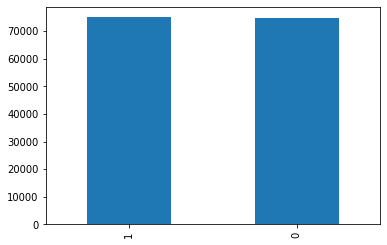

In [12]:
train_data['label'].value_counts().plot(kind='bar')

In [13]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


### (4) 데이터 정제하기

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [15]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True)    # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")    # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True)    # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any')    # Null 값 제거
print("전처리 후 테스트용 샘플의 개수 :", len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


### (5) 토큰화

In [16]:
# 임의의 문장에 대해서 테스트한 토큰화 결과
mecab = Mecab()
print(mecab.morphs("와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔"))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [17]:
# 불용어를 지정하여 필요없는 토큰들은 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [18]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x:[item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### (6) 단어와 길이 분포 확인하기

In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
# 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [21]:
# 긍정 리뷰에 대해서 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


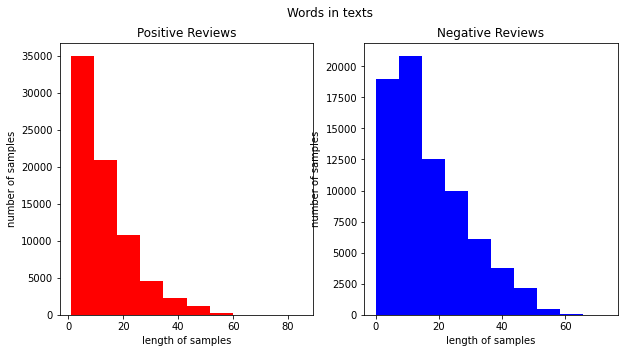

In [22]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x:len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print("긍정 리뷰의 평균 길이 :", np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print("부정 리뷰의 평균 길이 :", np.mean(text_len))
plt.show()

In [23]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

### (7) 정수 인코딩

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index)    # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0    # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0    # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수 : %s"%(threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수 : 18212
단어 집합에서 희귀 단어의 비율 : 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.79352492030765


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 oov 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print("단어 집합의 쿠기 :", vocab_size)

단어 집합의 쿠기 : 21787


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = "oov")
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [28]:
# x_train과 x_test 상위 3개의 샘플 출력
print(x_train[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [29]:
print(x_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


### (8) 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


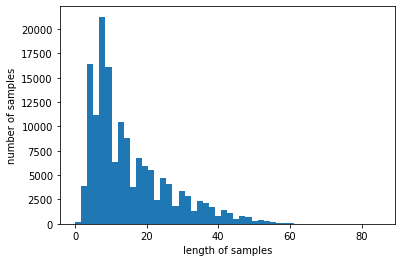

In [30]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포
print("리뷰의 최대 길이 :", max(len(review) for review in x_train))
print("리뷰의 평균 길이 :", sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if len(sentence) <= max_len:
      count += 1
  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s"%(max_len, (count/len(nested_list))*100))

In [34]:
# 최대길이를 80으로하면 몇개의 샘플을 온전히 보전할 수 있는지 확인
max_len = 80
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 : 99.99933302652553


In [35]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

## 3. GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [36]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es,mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2708 - acc: 0.8976
Epoch 00001: val_acc improved from -inf to 0.91957, saving model to best_model.h5
1875/1875 [==============================] - 438s 231ms/step - loss: 0.2708 - acc: 0.8976 - val_loss: 0.2235 - val_acc: 0.9196
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2142 - acc: 0.9225
Epoch 00002: val_acc improved from 0.91957 to 0.92420, saving model to best_model.h5
1875/1875 [==============================] - 338s 180ms/step - loss: 0.2142 - acc: 0.9225 - val_loss: 0.2100 - val_acc: 0.9242
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1975 - acc: 0.9291
Epoch 00003: val_acc improved from 0.92420 to 0.92520, saving model to best_model.h5
1875/1875 [==============================] - 273s 145ms/step - loss: 0.1975 - acc: 0.9291 - val_loss: 0.2084 - val_acc: 0.9252
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1865 - acc: 0.

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도 : %.4f" %(loaded_model.evaluate(x_test, y_test)[1]))

1562/1562 [==============================] - 41s 26ms/step - loss: 0.2088 - acc: 0.9251

 테스트 정확도 : 0.9251


## 4. 리뷰 예측해보기

In [39]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len)

  score = float(loaded_model.predict(pad_new))
  if score > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1-score)*100))

In [40]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.83% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.43% 확률로 부정 리뷰입니다.


# 8) BiLSTM으로 한국어 스팀 리뷰 감성 분류하기
## 3. 스팀 리뷰 데이터에 대한 이해와 전처리
- Mecab을 사전에 설치해야하나 위에 있으므로 여기서는 생략

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### (1) 데이터 로드하기

In [44]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f0060f6d410>)

In [49]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print("전체 리뷰 개수 :", len(total_data))

전체 리뷰 개수 : 100000


In [50]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [52]:
# 중복을 제외한 샘플의 수 카운트
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [53]:
# 중복인 샘플 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print("총 샘플의 수 :", len(total_data))

총 샘플의 수 : 99892


In [54]:
# Null 값 유무 확인
print(total_data.isnull().values.any())

False


### (2) 훈련 데이터와 테스트 데이터 분리

In [55]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print("훈련용 리뷰의 개수 :", len(train_data))
print("테스트용 리뷰의 개수 :", len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


### (3) 레이블의 분포 확인

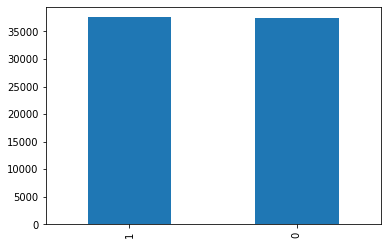

In [56]:
train_data['label'].value_counts().plot(kind='bar')

In [58]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  37376
1      1  37543


### (4) 데이터 정제하기

In [59]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


In [60]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True)    # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")    # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True)    # 공백은 Null값으로 변경
test_data = test_data.dropna(how='any')    # Null 값 제거
print("전처리 후 테스트용 샘플의 개수 :", len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


In [61]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

### (5) 토큰화

In [62]:
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### (6) 단어와 길이 분포 확인하기

In [63]:
negative_words = np.hstack(train_data[train_data.label==0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label==1]['tokenized'].values)

In [64]:
# 부정 리뷰 빈도수 상위 20개 단어
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [65]:
# 긍정 리뷰 빈도수 상위 20개 단어
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


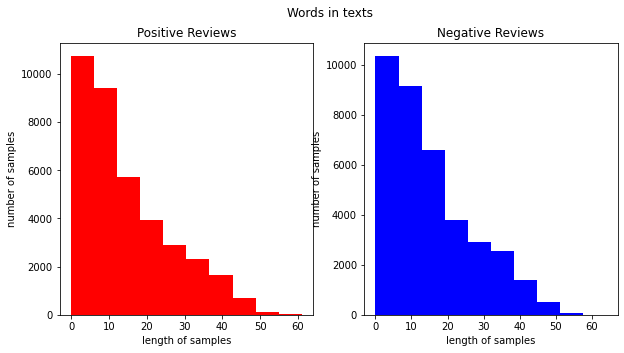

In [67]:
# 길이 분포 확인
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print("긍정 리뷰의 평균 길이 :", np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [68]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

### (7) 정수 인코딩

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [71]:
threshold = 2
total_cnt = len(tokenizer.word_index)    # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0    # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0    # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 회귀 단어의 수 : %s"%(threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 회귀 단어의 수 : 13878
단어 집합에서 희귀 단어의 비율 : 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.2254607619437832


In [72]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 oov 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print("단어 집합의 크기 :", vocab_size)

단어 집합의 크기 : 18941


In [73]:
tokenizer = Tokenizer(vocab_size, oov_token='oov')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [74]:
print(x_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [75]:
print(x_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3519, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


### (8) 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


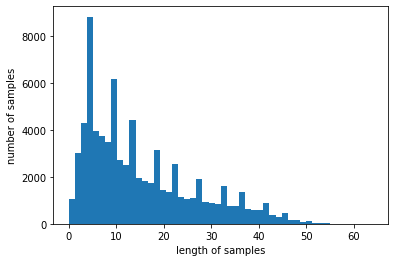

In [76]:
print("리뷰의 최대 길이 :", max(len(review) for review in x_train))
print("리뷰의 평균 길이 :", sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [77]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if len(sentence) <= max_len:
      count += 1

  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s"%(max_len, (count / len(nested_list))*100))

In [78]:
max_len = 60
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율 : 99.99599567532935


In [79]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

## 4. BiLSTM으로 스팀 리뷰 감성 분류하기

In [81]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))    # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5185 - acc: 0.7451
Epoch 00001: val_acc improved from -inf to 0.78277, saving model to best_model.h5
235/235 [==============================] - 246s 1s/step - loss: 0.5185 - acc: 0.7451 - val_loss: 0.4636 - val_acc: 0.7828
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4316 - acc: 0.8046
Epoch 00002: val_acc did not improve from 0.78277
235/235 [==============================] - 240s 1s/step - loss: 0.4316 - acc: 0.8046 - val_loss: 0.4828 - val_acc: 0.7801
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4057 - acc: 0.8189
Epoch 00003: val_acc improved from 0.78277 to 0.78484, saving model to best_model.h5
235/235 [==============================] - 248s 1s/step - loss: 0.4057 - acc: 0.8189 - val_loss: 0.4958 - val_acc: 0.7848
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3856 - acc: 0.8302
Epoch 00004: val_acc did not improve from 0.78484
235

In [82]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도 : %.4f" %(loaded_model.evaluate(x_test, y_test)[1]))

781/781 [==============================] - 25s 31ms/step - loss: 0.4794 - acc: 0.7859
테스트 정확도 : 0.7859


## 5. 리뷰 예측해보기

In [84]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
  new_sentence = mecab.morphs(new_sentence)    # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords]    # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence])    # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen=max_len)    # 패딩
  score = float(loaded_model.predict(pad_new))    # 예측
  if score > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1-score)*100))

In [85]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

95.91% 확률로 부정 리뷰입니다.


In [86]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

97.08% 확률로 긍정 리뷰입니다.
